<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Seasonal forecast anomalies

### About

This notebook provides you a practical introduction how to calculate seasonal forecast anomalies with data from the [ECMWF SEAS5 model](https://confluence.ecmwf.int/display/CKB/Description+of+SEAS5+C3S+contribution). The workflow shows you how to compute a hindcast climate mean for the climate reference period 1993 to 2016 and this hindcast climate mean is used to compute real-time forecast anomalies. At the end, the the computed anomalies are compared with precomputed seasonal forecast anomalies offered by the Copernicus Climate Data Store.
The example showcases global real-time forecast anomalies for September 2021 and five leadtime months (until February 2022).


The notebook has the following outline:

* [1 - Calculate seasonal hindcast climate mean](#hindcast_climate_mean)
* [2 - Load monthly seasonal forecast data for September 2021](#seasonal_forecast_load)
* [3 - Calculate seasonal forecast anomalies for September 2021](#seasonal_anomalies_calculate)
* [4 - Compare the calculated anomalies with precomputed seasonal forecast anomalies offered by the CDS](#seasonal_anomalies_compare)

### Data

This notebook introduces you to the `seasonal forecast monthly statistics` and `seasonal forecast anomalies` on single levels. The data used in the notebook has the following specifications:

> **Data**: `Seasonal forecast monthly statistics on single levels - Hindcast data` <br>
> **Temporal coverage**: `Sep 1993 to Sep 2016` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve requests**: 
> * [CDS API request - Hindcast individual members](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast)
> * [CDS API request - Hindcast climate mean](./100_climate_data_store_intro.ipynb#seas5_monthly_hindcast_mean)

<br>

> **Data**: `Seasonal forecast monthly statistics on single levels - Forecast data` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#seas5_monthly_forecast)

<br>

> **Data**: `Seasonal forecast anomalies on single levels` <br>
> **Temporal coverage**: `Sep 2021` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `GRIB`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#seas5_monthly_anomalies)

<br>

Get [here](./101_c3s_data_intro.ipynb#seasonal_forecasts) more information about seasonal forecast data in general including an overview of the different dataset types.

<hr>

### Load libraries

In [199]:
# CDS API
import cdsapi

import cfgrib
# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for working with dates
from dateutil.relativedelta import relativedelta
from calendar import monthrange

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

#Interactive widgets
import ipywidgets as widgets

### Load helper functions

In [2]:
%run ./functions.ipynb

<hr>

## <a id='hindcast_climate mean'></a>1. Calculate seasonal hindcast climate mean

The example below will show you how to calculate seasonal forecast anomalies of total precipitation for September 2021 and for five leadtime months (until February 2022). 
The term anomaly refers to the deviation of a value from the long-term average. A positive anomaly indicates that the average precipitation of this month was higher than the reference value, while a negative anomaly indicates that during this specific month, it rained less and it was drier than the reference value.

The first step is to calculate the hindcast climate mean for September, which is the longterm average of precipitation for seasonal forecasts with a start runtim in September and five lead time months (until February). The reference period for the seasonal hindcast data is from 1993 to 2016 and the hindcast climate mean represents the average conditions observed over this period. 

Seasonal forecast data are disseminated in the `GRIB` data format. You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read GRIB files from ECMWF. To read a GRIB file, you have to specify the keyword argument `engine` and specify `'cfgrib'`. [cfgrib](https://github.com/ecmwf/cfgrib) is a Python interface to map GRIB files to the NetCDF Common Data Model using [ecCodes](https://github.com/ecmwf/eccodes).

The result is a `xarray.Dataset` object with five dimensions: `number`, `time`, `step`, `latitude` and `longitude`. 

In [3]:
ds = xr.open_dataset('./data/ecmwf_seas5_1993-2016_05_hindcast_monthly.grib', engine='cfgrib')
ds

<xarray.Dataset>
Dimensions:     (number: 25, time: 24, step: 6, latitude: 181, longitude: 360)
Coordinates:
  * number      (number) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 1993-05-01 1994-05-01 ... 2016-05-01
  * step        (step) timedelta64[ns] 31 days 61 days ... 153 days 184 days
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    tprate      (number, time, step, latitude, longitude) float32 ...
    sst         (number, time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-16T09:22 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

Per default, xarray does not load the GRIB file in a structure useful for us. You can specify a custom data structure by identifying the keyword argument `backend_kwargs` and specifically highligting the two dimensions that shall be used for the time dimensions. When you do this, you see that the resulting `xarray.Dataset` has five dimensions:
* `number`: Number of ensembles (25)
* `forecastMonth`: leadtime months (6, including the startime run)
* `time`: number of years (24, from 1993 to 2016)
* `latitude`: latitudes (181 -> 1 deg resolution)
* `longitude`: longitudes (360 --> 1 deg resolution)

In [4]:
ds_hindcast = xr.open_dataset('./data/ecmwf_seas5_1993-2016_05_hindcast_monthly.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')), filter_by_keys={'shortName':'tprate'})
ds_hindcast

Ignoring index file './data/ecmwf_seas5_1993-2016_05_hindcast_monthly.grib.779cf.idx' older than GRIB file


<xarray.Dataset>
Dimensions:        (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-05-01 1994-05-01 ... 2016-05-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    tprate         (number, forecastMonth, time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-16T09:23 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

The next step is to load the data variable `tprate` as `xarray.DataArray`. You can load a DataArray from a Dataset by specifying the name of the variable in square brackets `[]`. A xarray.DataArray provides you additional attributes of the variable. For example, you see that the precipitation is given in accumulations with the unit m/s. Since these conversion from precipitation rate in m/s to total precipitation for a month in m depends on the number of days per month, we will execute the conversion in a later step. You find more information about the conversion of accumulated variables [here](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790).

In [5]:
tprate_hindcast = ds_hindcast['tprate']
tprate_hindcast

<xarray.DataArray 'tprate' (number: 25, forecastMonth: 6, time: 24, latitude: 181, longitude: 360)>
[234576000 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-05-01 1994-05-01 ... 2016-05-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes:
    GRIB_paramId:                             172228
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  360
    GRIB_Ny:                                  181
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           tprate
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_iDirectionIncrementInDegrees:        1.0
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        1.0
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.0
    GRIB_missingValue:                        9999
    GRIB_name:                                Mean total precipitation rate
    GRIB_shortName:                           tprate
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                Mean total precipitation rate
    units:                                    m s**-1
    standard_name:                            unknown

Since we are interested in creating the `hindcast climate mean`, the next step is to create the average over the 25 ensemble members and the 24 start years. You can use the function `mean()` in order to average over one or more given dimensions. The dimension we want to create the longterm mean are `number` (25 ensemble members) and `time` (start time years from 1993 to 2016). The result is a `xarray.DataArray` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

The DataArray `tprate_hindcast_mean` is the hindcast climate mean for the month September and five leadtime months, over the reference period 1993 to 2016.

**Note:** with the averaging operation, your `xarray.DataArray` loses its attributes. Before the final visualisation of the computed anomalies ([here](#seas5_anomalies)), we will show you how to add and modify attributes of a xarray.DataArray.

In [6]:
tprate_hindcast_mean = tprate_hindcast.mean(['number', 'time'])
tprate_hindcast_mean

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[7.27389615e-09, 7.27389615e-09, 7.27389615e-09, ...,
         7.27389615e-09, 7.27389615e-09, 7.27389615e-09],
        [7.05738801e-09, 7.06172898e-09, 7.06613124e-09, ...,
         7.02487624e-09, 7.03560854e-09, 7.04628000e-09],
        [6.97020974e-09, 6.98274860e-09, 6.99498459e-09, ...,
         6.92369229e-09, 6.93917768e-09, 6.95467550e-09],
        ...,
        [1.82400983e-09, 1.81782522e-09, 1.81168924e-09, ...,
         1.84227245e-09, 1.83622129e-09, 1.83006099e-09],
        [2.29911779e-09, 2.29435204e-09, 2.28950126e-09, ...,
         2.31278441e-09, 2.30798225e-09, 2.30361663e-09],
        [2.70048384e-09, 2.70048384e-09, 2.70048384e-09, ...,
         2.70048384e-09, 2.70048384e-09, 2.70048384e-09]],

       [[1.09858567e-08, 1.09858567e-08, 1.09858567e-08, ...,
         1.09858567e-08, 1.09858567e-08, 1.09858567e-08],
        [1.03791900e-08, 1.03840039e-08, 1.03888187e-08, ...,
         1.03511049e-08, 1.03604423e-08, 1.03695976e-08],
        [1.00812407e-08, 1.01029229e-08, 1.01244479e-08, ...,
         1.00160129e-08, 1.00379500e-08, 1.00590860e-08],
...
        [1.44419199e-09, 1.43627332e-09, 1.43029510e-09, ...,
         1.46575330e-09, 1.45882895e-09, 1.45046153e-09],
        [1.81951088e-09, 1.81518167e-09, 1.80927595e-09, ...,
         1.83453575e-09, 1.82824200e-09, 1.82482229e-09],
        [2.13508144e-09, 2.13508144e-09, 2.13508144e-09, ...,
         2.13508144e-09, 2.13508144e-09, 2.13508144e-09]],

       [[9.10134101e-09, 9.10134101e-09, 9.10134101e-09, ...,
         9.10134101e-09, 9.10134101e-09, 9.10134101e-09],
        [9.29670030e-09, 9.30316357e-09, 9.30803878e-09, ...,
         9.26988797e-09, 9.27865607e-09, 9.28798105e-09],
        [9.43461576e-09, 9.45326661e-09, 9.47201428e-09, ...,
         9.36220790e-09, 9.38479960e-09, 9.41219369e-09],
        ...,
        [1.38621803e-09, 1.38139167e-09, 1.37470990e-09, ...,
         1.40482015e-09, 1.39895096e-09, 1.39447620e-09],
        [1.74624459e-09, 1.74307957e-09, 1.74176984e-09, ...,
         1.75345993e-09, 1.75191983e-09, 1.74754211e-09],
        [2.07671835e-09, 2.07671835e-09, 2.07671835e-09, ...,
         2.07671835e-09, 2.07671835e-09, 2.07671835e-09]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<br>

## <a id='seasonal_forecast_load'></a>2. Load monthly seasonal forecast data for September 2021

The next step is to load the real-time seasonal forecast data for September 2021 and five leadtime months. We open the dataset `ecmwf_seas5_2021_09_forecast_monthly_tp.grib` with the xarray function `open_dataset()`, where we again specify the two keyword arguments `engine` and `backend_kwargs`. See [here](.100_climate_data_store_intro.ipynb#seas5_monthly_forecast) the CDS API data request used.

Once the the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
* `number`: 51 ensemble members
* `forecastMonth`: 6 leadtime months, including September, the month of the model run
* `latitude`: latitude values
* `longitude`: longitude values

Compared to the hindcast data, we do not have the dimension `time`, as the data only holds information for the year 2021. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, who only have 25 ensemble members.

In [7]:
seas5_forecast = xr.open_dataset('./data/ecmwf_seas5_2021_05_forecast_monthly_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
seas5_forecast

<xarray.Dataset>
Dimensions:        (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    tprate         (number, forecastMonth, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-16T09:25 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

Now, we can also build the average over the 51 ensemble members of the seasonal forecast data for September 2021. You can use the xarray function `mean()` and specify the dimension name `number` to do so. The result is a `xarray.Dataset` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

**Note**: as a result of the averaging process, the xarray.Dataset looses again its attribute information.

<div class="alert alert-block alert-warning">

`CHANGE of APPROACH`
 - better start with individual members (not ensemble mean). The 'ensemble_mean' anomaly can always be calculated at a latter stage, and we'd like to stress the importance of using the whole ensemble distribution. The idea is to keep doing all the calculations with all the members.
    
</div>

In [ ]:
# seas5_forecast_mean = seas5_forecast.mean(['number'])
# seas5_forecast_mean

Now, we have loaded and prepared the two dataset we require and we can continue to calculate the seasonal forecast anomalies for September 2021.

<br>

## <a id='seas5_anomalies'></a> 3. Calculate seasonal forecast anomalies for September 2021

Now, we can compute the seasonal forecast anomalies for September 2021. You can compute the anomalies by subtracting the longterm average (`tprate_hindcast_mean`) from the seasonal forecast real-time data for September 2021 (`seas5_forecast_mean`).

The resulting `xarray.DataArray` has the anomaly information for each of the leadtime months from September 2021 to February 2022 relative to the reference period September 1993 to 2016.

In [9]:
seas5_anomalies_202105 = seas5_forecast['tprate'] - tprate_hindcast_mean
seas5_anomalies_202105

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[[ 6.78725520e-10,  6.78725520e-10,  6.78725520e-10, ...,
           6.78725520e-10,  6.78725520e-10,  6.78725520e-10],
         [ 7.56683605e-12,  3.96056521e-11,  6.43072262e-11, ...,
          -2.54050114e-11, -1.43094425e-11, -3.15303339e-12],
         [ 2.91195956e-10,  3.00484970e-10,  2.95524938e-10, ...,
           2.21298091e-10,  2.42192488e-10,  2.70350409e-10],
         ...,
         [ 8.97198316e-10,  8.81555051e-10,  8.80415074e-10, ...,
           9.15315490e-10,  9.06814734e-10,  9.05699071e-10],
         [ 6.54921006e-10,  6.30582919e-10,  6.28157748e-10, ...,
           6.70358213e-10,  6.67884414e-10,  6.57698118e-10],
         [ 5.15489429e-10,  5.15489429e-10,  5.15489429e-10, ...,
           5.15489429e-10,  5.15489429e-10,  5.15489429e-10]],

        [[ 3.54996033e-11,  3.54996033e-11,  3.54996033e-11, ...,
           3.54996033e-11,  3.54996033e-11,  3.54996033e-11],
         [ 5.40302914e-10,  5.35488986e-10,  5.30674171e-10, ...,
           4.51972682e-10,  4.86291007e-10,  5.06239495e-10],
         [-3.25901084e-10, -2.45719889e-10, -1.79933402e-10, ...,
          -4.64400074e-10, -4.13577617e-10, -3.76505938e-10],
...
           4.16999990e-10,  4.45752213e-10,  4.54119631e-10],
         [ 4.63420080e-10,  4.67749284e-10,  4.95482877e-10, ...,
           4.26567337e-10,  4.32861080e-10,  4.58108662e-10],
         [ 5.98958882e-10,  5.98958882e-10,  5.98958882e-10, ...,
           5.98958882e-10,  5.98958882e-10,  5.98958882e-10]],

        [[-4.04343936e-09, -4.04343936e-09, -4.04343936e-09, ...,
          -4.04343936e-09, -4.04343936e-09, -4.04343936e-09],
         [-3.64217012e-09, -3.69956510e-09, -3.70444031e-09, ...,
          -3.66628949e-09, -3.67505759e-09, -3.68438258e-09],
         [-3.14707727e-09, -3.20938387e-09, -3.18447579e-09, ...,
          -3.11832515e-09, -3.14091686e-09, -3.16831095e-09],
         ...,
         [ 1.21240995e-09,  1.21723631e-09,  1.18026233e-09, ...,
           1.28111932e-09,  1.24333277e-09,  1.24780752e-09],
         [ 1.12159382e-09,  1.12475884e-09,  1.12606857e-09, ...,
           1.16531018e-09,  1.16685028e-09,  1.17122800e-09],
         [ 1.11126219e-09,  1.11126219e-09,  1.11126219e-09, ...,
           1.11126219e-09,  1.11126219e-09,  1.11126219e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-05-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<div class="alert alert-block alert-warning">

### is this really needed? plots seem to work without this
    
Above, if you have a closer look at the `longitude` information, you see that per default, seasonal forecast data are disseminated on a longitude grid ranging from [0, 360]. For standard visualisations with the plotting library [matplotlib](https://matplotlib.org/), it is better to assign the coordinates to a grid from [-180, 180]. You can use the xarray function `assign_coords` to reassign the longitude values. After the values have been reassigned, you have to sort the longitude values. For sorting, you can use the function `sortby()`.

A check of the data array shows you that the longitude values now range from [-180, 180] and are also sorted in an ascending order.
    
</div>

In [ ]:
# seas5_anomalies_202109_tp_new = seas5_anomalies_202109.assign_coords(longitude=(((seas5_anomalies_202109.longitude + 180) % 360) - 180)).sortby('longitude')
# seas5_anomalies_202109_tp_new

<br>

<div class="alert alert-block alert-warning">

`REVIEW TEXT and EXPLAIN CALCULATION of NUMDAYS,etc`

Before visualizing the seasonal forecast anomalies, let us convert the precipitation accumulations in m/s to total precipitation for a month in mm. The conversion has to be done per month, as it is dependent on the number of days of a specific month. Let us start with e.g. the values for September. We multiply the accumulations with 30 (for 30 days in September), then with (24 * 60 * 60) to retrieve precipitation values in m. As a last step, you can convert the values in m to precipitation in mm by multiplying the values with 1000.
</div>

In [10]:
vt = [ pd.to_datetime(seas5_anomalies_202105.time.values) + relativedelta(months=fcmonth-1) for fcmonth in seas5_anomalies_202105.forecastMonth]
numdays = [monthrange(dd.year,dd.month)[1] for dd in vt]
seas5_anomalies_202105 = seas5_anomalies_202105.assign_coords(valid_time=('forecastMonth',vt))
seas5_anomalies_202105 = seas5_anomalies_202105.assign_coords(numdays=('forecastMonth',numdays))
seas5_anomalies_202105

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[[ 6.78725520e-10,  6.78725520e-10,  6.78725520e-10, ...,
           6.78725520e-10,  6.78725520e-10,  6.78725520e-10],
         [ 7.56683605e-12,  3.96056521e-11,  6.43072262e-11, ...,
          -2.54050114e-11, -1.43094425e-11, -3.15303339e-12],
         [ 2.91195956e-10,  3.00484970e-10,  2.95524938e-10, ...,
           2.21298091e-10,  2.42192488e-10,  2.70350409e-10],
         ...,
         [ 8.97198316e-10,  8.81555051e-10,  8.80415074e-10, ...,
           9.15315490e-10,  9.06814734e-10,  9.05699071e-10],
         [ 6.54921006e-10,  6.30582919e-10,  6.28157748e-10, ...,
           6.70358213e-10,  6.67884414e-10,  6.57698118e-10],
         [ 5.15489429e-10,  5.15489429e-10,  5.15489429e-10, ...,
           5.15489429e-10,  5.15489429e-10,  5.15489429e-10]],

        [[ 3.54996033e-11,  3.54996033e-11,  3.54996033e-11, ...,
           3.54996033e-11,  3.54996033e-11,  3.54996033e-11],
         [ 5.40302914e-10,  5.35488986e-10,  5.30674171e-10, ...,
           4.51972682e-10,  4.86291007e-10,  5.06239495e-10],
         [-3.25901084e-10, -2.45719889e-10, -1.79933402e-10, ...,
          -4.64400074e-10, -4.13577617e-10, -3.76505938e-10],
...
           4.16999990e-10,  4.45752213e-10,  4.54119631e-10],
         [ 4.63420080e-10,  4.67749284e-10,  4.95482877e-10, ...,
           4.26567337e-10,  4.32861080e-10,  4.58108662e-10],
         [ 5.98958882e-10,  5.98958882e-10,  5.98958882e-10, ...,
           5.98958882e-10,  5.98958882e-10,  5.98958882e-10]],

        [[-4.04343936e-09, -4.04343936e-09, -4.04343936e-09, ...,
          -4.04343936e-09, -4.04343936e-09, -4.04343936e-09],
         [-3.64217012e-09, -3.69956510e-09, -3.70444031e-09, ...,
          -3.66628949e-09, -3.67505759e-09, -3.68438258e-09],
         [-3.14707727e-09, -3.20938387e-09, -3.18447579e-09, ...,
          -3.11832515e-09, -3.14091686e-09, -3.16831095e-09],
         ...,
         [ 1.21240995e-09,  1.21723631e-09,  1.18026233e-09, ...,
           1.28111932e-09,  1.24333277e-09,  1.24780752e-09],
         [ 1.12159382e-09,  1.12475884e-09,  1.12606857e-09, ...,
           1.16531018e-09,  1.16685028e-09,  1.17122800e-09],
         [ 1.11126219e-09,  1.11126219e-09,  1.11126219e-09, ...,
           1.11126219e-09,  1.11126219e-09,  1.11126219e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-05-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     (forecastMonth) datetime64[ns] 2021-05-01 ... 2021-10-01
    numdays        (forecastMonth) int64 31 30 31 31 30 31

In [11]:
seas5_anomalies_202105_tp = seas5_anomalies_202105 * seas5_anomalies_202105.numdays * 24 * 60 * 60 * 1000
seas5_anomalies_202105_tp

<xarray.DataArray (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[[ 1.81789843e+00,  1.81789843e+00,  1.81789843e+00, ...,
           1.81789843e+00,  1.81789843e+00,  1.81789843e+00],
         [ 2.02670137e-02,  1.06079779e-01,  1.72240475e-01, ...,
          -6.80447826e-02, -3.83264108e-02, -8.44508463e-03],
         [ 7.79939249e-01,  8.04818944e-01,  7.91533994e-01, ...,
           5.92724807e-01,  6.48688361e-01,  7.24106535e-01],
         ...,
         [ 2.40305597e+00,  2.36115705e+00,  2.35810373e+00, ...,
           2.45158101e+00,  2.42881258e+00,  2.42582439e+00],
         [ 1.75414042e+00,  1.68895329e+00,  1.68245771e+00, ...,
           1.79548744e+00,  1.78886162e+00,  1.76157864e+00],
         [ 1.38068689e+00,  1.38068689e+00,  1.38068689e+00, ...,
           1.38068689e+00,  1.38068689e+00,  1.38068689e+00]],

        [[ 9.20149716e-02,  9.20149716e-02,  9.20149716e-02, ...,
           9.20149716e-02,  9.20149716e-02,  9.20149716e-02],
         [ 1.40046515e+00,  1.38798745e+00,  1.37550745e+00, ...,
           1.17151319e+00,  1.26046629e+00,  1.31217277e+00],
         [-8.44735609e-01, -6.36905952e-01, -4.66387377e-01, ...,
          -1.20372499e+00, -1.07199318e+00, -9.75903390e-01],
...
         [ 1.19332873e+00,  1.21385391e+00,  1.22934945e+00, ...,
           1.08086397e+00,  1.15538974e+00,  1.17707808e+00],
         [ 1.20118485e+00,  1.21240614e+00,  1.28429162e+00, ...,
           1.10566254e+00,  1.12197592e+00,  1.18741765e+00],
         [ 1.55250142e+00,  1.55250142e+00,  1.55250142e+00, ...,
           1.55250142e+00,  1.55250142e+00,  1.55250142e+00]],

        [[-1.08299480e+01, -1.08299480e+01, -1.08299480e+01, ...,
          -1.08299480e+01, -1.08299480e+01, -1.08299480e+01],
         [-9.75518845e+00, -9.90891516e+00, -9.92197293e+00, ...,
          -9.81978978e+00, -9.84327425e+00, -9.86825029e+00],
         [-8.42913175e+00, -8.59601376e+00, -8.52929997e+00, ...,
          -8.35212209e+00, -8.41263172e+00, -8.48600404e+00],
         ...,
         [ 3.24731881e+00,  3.26024574e+00,  3.16121463e+00, ...,
           3.43134999e+00,  3.33014249e+00,  3.34212767e+00],
         [ 3.00407688e+00,  3.01255408e+00,  3.01606206e+00, ...,
           3.12116679e+00,  3.12529180e+00,  3.13701708e+00],
         [ 2.97640466e+00,  2.97640466e+00,  2.97640466e+00, ...,
           2.97640466e+00,  2.97640466e+00,  2.97640466e+00]]]])
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-05-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     (forecastMonth) datetime64[ns] 2021-05-01 ... 2021-10-01
    numdays        (forecastMonth) int64 31 30 31 31 30 31

<br>

As a last step, we can now reassign the attributes to the `xarray.DataArray` above. Let us take the attributes from the original data file `seas5_forecast` and assign it to the DataArray `seas5_anomalies_202109`. You can use the function `assign_attrs()` from the xarray library. Additionally, you want to update the attributes `units` and `long_name`, as they have changed with the previous workflow steps. You can simply specify the name of a attribute (e.g. `units`) and assign it a new value.


<div class="alert alert-block alert-warning">

`AVOID REASSIGNING ALL ATTRS`

The averaging operation has changed what we have now, so inheriting some attributes from the original dataset (e.g. many GRIB keywords) can be misleading. Much better to just add those we'd like to have.
    
Additionally, we'd probably want to separate the "long_name" of the variable from the "title" we'll be using later

</div>

In [12]:
# seas5_anomalies_202109_tp = seas5_anomalies_202109_tp.assign_attrs(seas5_forecast['tprate'].attrs)
# seas5_anomalies_202109_tp

seas5_anomalies_202105_tp.attrs['units'] = 'mm'
seas5_anomalies_202105_tp.attrs['long_name'] = 'Total precipitation anomaly'
seas5_anomalies_202105_tp

<xarray.DataArray (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[[ 1.81789843e+00,  1.81789843e+00,  1.81789843e+00, ...,
           1.81789843e+00,  1.81789843e+00,  1.81789843e+00],
         [ 2.02670137e-02,  1.06079779e-01,  1.72240475e-01, ...,
          -6.80447826e-02, -3.83264108e-02, -8.44508463e-03],
         [ 7.79939249e-01,  8.04818944e-01,  7.91533994e-01, ...,
           5.92724807e-01,  6.48688361e-01,  7.24106535e-01],
         ...,
         [ 2.40305597e+00,  2.36115705e+00,  2.35810373e+00, ...,
           2.45158101e+00,  2.42881258e+00,  2.42582439e+00],
         [ 1.75414042e+00,  1.68895329e+00,  1.68245771e+00, ...,
           1.79548744e+00,  1.78886162e+00,  1.76157864e+00],
         [ 1.38068689e+00,  1.38068689e+00,  1.38068689e+00, ...,
           1.38068689e+00,  1.38068689e+00,  1.38068689e+00]],

        [[ 9.20149716e-02,  9.20149716e-02,  9.20149716e-02, ...,
           9.20149716e-02,  9.20149716e-02,  9.20149716e-02],
         [ 1.40046515e+00,  1.38798745e+00,  1.37550745e+00, ...,
           1.17151319e+00,  1.26046629e+00,  1.31217277e+00],
         [-8.44735609e-01, -6.36905952e-01, -4.66387377e-01, ...,
          -1.20372499e+00, -1.07199318e+00, -9.75903390e-01],
...
         [ 1.19332873e+00,  1.21385391e+00,  1.22934945e+00, ...,
           1.08086397e+00,  1.15538974e+00,  1.17707808e+00],
         [ 1.20118485e+00,  1.21240614e+00,  1.28429162e+00, ...,
           1.10566254e+00,  1.12197592e+00,  1.18741765e+00],
         [ 1.55250142e+00,  1.55250142e+00,  1.55250142e+00, ...,
           1.55250142e+00,  1.55250142e+00,  1.55250142e+00]],

        [[-1.08299480e+01, -1.08299480e+01, -1.08299480e+01, ...,
          -1.08299480e+01, -1.08299480e+01, -1.08299480e+01],
         [-9.75518845e+00, -9.90891516e+00, -9.92197293e+00, ...,
          -9.81978978e+00, -9.84327425e+00, -9.86825029e+00],
         [-8.42913175e+00, -8.59601376e+00, -8.52929997e+00, ...,
          -8.35212209e+00, -8.41263172e+00, -8.48600404e+00],
         ...,
         [ 3.24731881e+00,  3.26024574e+00,  3.16121463e+00, ...,
           3.43134999e+00,  3.33014249e+00,  3.34212767e+00],
         [ 3.00407688e+00,  3.01255408e+00,  3.01606206e+00, ...,
           3.12116679e+00,  3.12529180e+00,  3.13701708e+00],
         [ 2.97640466e+00,  2.97640466e+00,  2.97640466e+00, ...,
           2.97640466e+00,  2.97640466e+00,  2.97640466e+00]]]])
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-05-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     (forecastMonth) datetime64[ns] 2021-05-01 ... 2021-10-01
    numdays        (forecastMonth) int64 31 30 31 31 30 31
Attributes:
    units:      mm
    long_name:  Total precipitation anomaly

regional subselection

In [13]:
def ds_latlon_subset(ds,area,latname='latitude',lonname='longitude'):
    
    mask = (ds[latname]<=area[0]) & (ds[latname]>=area[2]) & (ds[lonname]<=area[3]%360) & (ds[lonname]>=area[1]%360)
    dsout = ds.where(mask,drop=True)
    
    return dsout


SAsia = (30,70,5,90) #'North/West/South/East'

In [20]:
subselregion = SAsia
seas5_anomalies_202105_SAsia = ds_latlon_subset(seas5_anomalies_202105_tp, subselregion)

stamp plot of all members

similar to https://apps.ecmwf.int/webapps/opencharts/products/mofc_multi_eps_family_stamps

<div class="alert alert-block alert-warning">

`ToDo: additional changes PLOTS`
  

- improve layout (axis labels, titles, single colorbar, etc...)


</div>

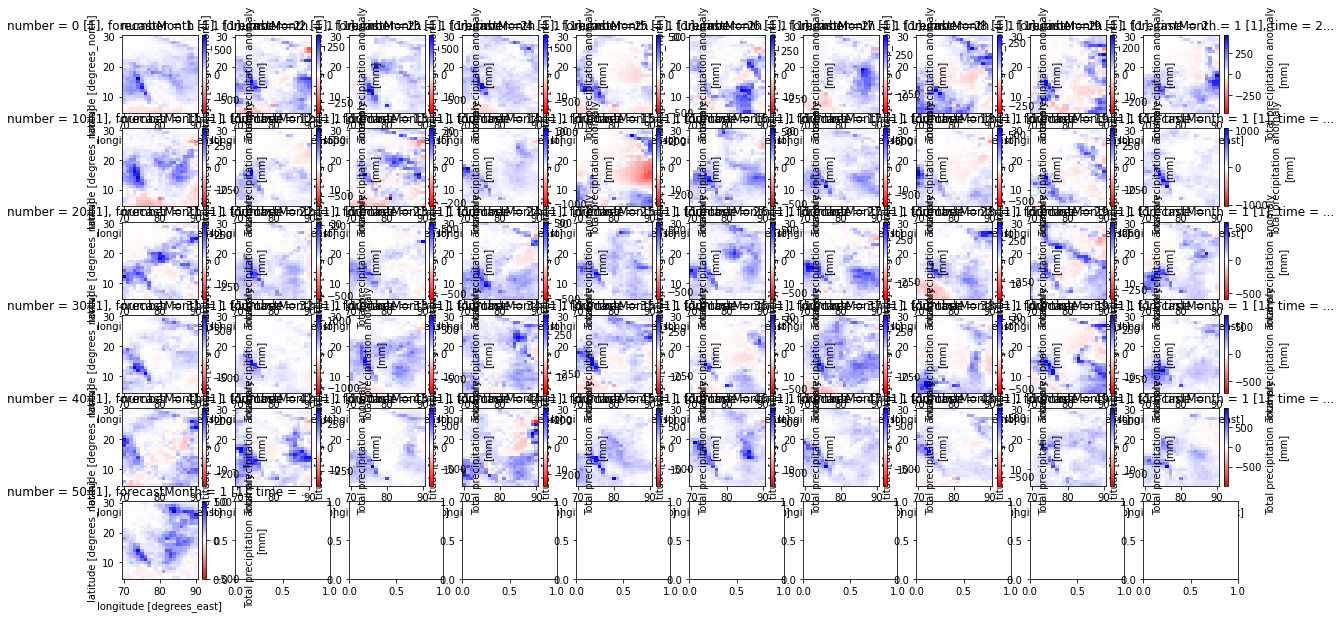

In [192]:
leadt=1
fig, axs = plt.subplots(6, 10, figsize=(20,10))

for member in seas5_anomalies_202105_SAsia.number.values:
    seas5_anomalies_202105_SAsia.sel(number=member,forecastMonth=leadt).plot(ax=axs.flatten()[member],cmap='bwr_r')


plot anomalies (all members) + climatology (terciles)


first, calculate average over the region selected (weighted with cell area, estimated using cos(lat))

In [67]:
w=np.cos(np.deg2rad(seas5_anomalies_202105_SAsia.latitude))

anoms_SAsia = seas5_anomalies_202105_SAsia.weighted(w).mean(['latitude','longitude'])
anoms_SAsia = anoms_SAsia.drop_vars(['time','surface','numdays']).to_dataframe(name='anom')
anoms_SAsia = anoms_SAsia.reset_index().drop('forecastMonth',axis=1).set_index(['valid_time','number']).unstack()

In [86]:
tprate_hindcast_SAsia = ds_latlon_subset(tprate_hindcast, subselregion)
tprate_hindcast_SAsia = tprate_hindcast_SAsia.weighted(w).mean(['latitude','longitude'])


calculate climatology boundaries

In [109]:
anom_hindcast = tprate_hindcast_SAsia - tprate_hindcast_SAsia.mean(['number','time'])

In [111]:
# To calculate number of days, it uses the first year in the hindcast (i.e. ignores leap years)
vt = [ pd.to_datetime(anom_hindcast.time.values[0]) + relativedelta(months=fcmonth-1) for fcmonth in anom_hindcast.forecastMonth]
numdays = [monthrange(dd.year,dd.month)[1] for dd in vt]
anom_hindcast = anom_hindcast.assign_coords(numdays=('forecastMonth',numdays))


anom_hindcast_tp = anom_hindcast * anom_hindcast.numdays * 24 * 60 * 60 * 1000

In [253]:
P0=anom_hindcast_tp.min(['number','time'])
P33=anom_hindcast_tp.quantile(0.33,['number','time'])
P66=anom_hindcast_tp.quantile(0.66,['number','time'])
P100=anom_hindcast_tp.max(['number','time'])

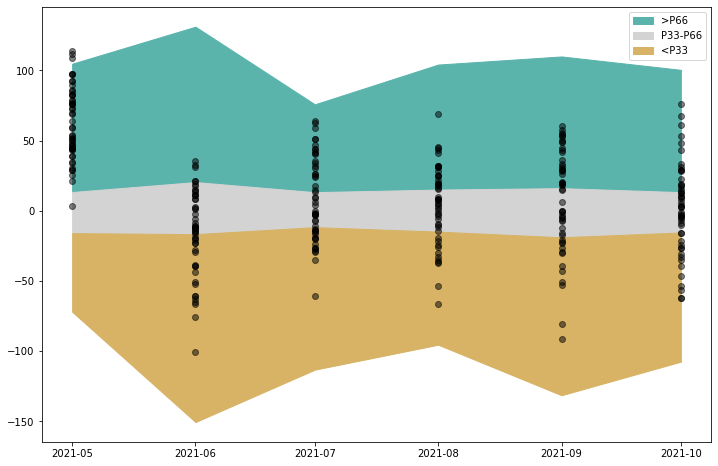

In [328]:
fig=plt.figure(figsize=(12, 8))
thisax=fig.gca()
# anoms_SAsia.plot(ax=thisax, linestyle='dotted', color='green', legend=False, label='')
# anoms_SAsia.plot(ax=thisax, marker='o', linestyle='', color='black', alpha=0.5, legend=False)
thisax.plot(anoms_SAsia, marker='o', linestyle='', color='black', alpha=0.5, label='_nolegend_')
thisax.fill_between(anoms_SAsia.index,P66,P100,color='#5ab4ac',label='>P66')
thisax.fill_between(anoms_SAsia.index,P33,P66,color='lightgray',label='P33-P66')
thisax.fill_between(anoms_SAsia.index,P0,P33,color='#d8b365',label='<P33')
plt.legend()

## <a id='seas5_anomalies_3months'></a> 3b. Calculate seasonal forecast 3-month anomalies

<div class="alert alert-block alert-warning">

`New section for these 3-month aggregations`

</div>

First, calculate 3-month rolling averages.

Then, hindcast climate mean, individual members anomalies and ensemble mean anomaly

In [283]:
seas5_forecast_3m = seas5_forecast.rolling(forecastMonth=3).mean()
ds_hindcast_3m = ds_hindcast.rolling(forecastMonth=3).mean()

ds_hindcast_3m_hindcast_mean = ds_hindcast_3m.mean(['number','time'])

In [309]:
seas5_anomalies_3m_202105 = seas5_forecast_3m.tprate - ds_hindcast_3m_hindcast_mean.tprate
seas5_anomalies_3m_202105_em = seas5_anomalies_3m_202105.mean('number')


Calculate valid times and number of days fot the 3 month periods.

Convert tprate to accumulation (using number of days)

In [317]:
vt = [ pd.to_datetime(seas5_anomalies_3m_202105_em.time.values) + relativedelta(months=fcmonth-1) for fcmonth in seas5_anomalies_3m_202105_em.forecastMonth]
vts = [[thisvt+relativedelta(months=-mm) for mm in range(3)] for thisvt in vt]
numdays = [np.sum([monthrange(dd.year,dd.month)[1] for dd in d3]) for d3 in vts]
vts_names = ['{}{}{} {}'.format(d3[2].strftime('%b')[0],d3[1].strftime('%b')[0],d3[0].strftime('%b')[0], d3[0].strftime('%Y'))  for d3 in vts]

seas5_anomalies_3m_202105_em = seas5_anomalies_3m_202105_em.assign_coords(numdays=('forecastMonth',numdays))
seas5_anomalies_3m_202105_em = seas5_anomalies_3m_202105_em.assign_coords(valid_time=('forecastMonth',vts_names))

seas5_anomalies_3m_202105_em_tp = seas5_anomalies_3m_202105_em * seas5_anomalies_3m_202105_em.numdays * 24 * 60 * 60 * 1000

seas5_anomalies_3m_202105_em_tp.attrs['units'] = 'mm'
seas5_anomalies_3m_202105_em_tp.attrs['long_name'] = 'Total precipitation ensemble mean anomaly'

Now, we can visualize the seasonal forecast anomalies for September 2021. You can use the function [visualize_pcolormesh()](./functions.ipynb#visualize_pcolormesh) to visualize the global seasonal forecast anomalies with the libraries [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/). <br>
The function takes the following keyword arguments:
* `data_array`: xarray.DataArray
* `longitude`, `latitude`: longitude and latitude coordinates
* `projection`: one of [Cartopy's projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)
* `color_scale`: one of [matplotlib's colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
* `unit`: can be taken from the data's attributes
* `long_name`: can be taken from the data's attributes
* `vmin`, `vmax`: minimum and maximum values for color range
* `set_global` (optional): ability to also show a geographic subset
* `lonmin`, `lonmax`, `latmin`, `latmax` (optional): ability to specify a bounding box

<div class="alert alert-block alert-warning">

`ToDo: additional changes PLOTS`
  

- try to reproduce a similar plot to the ones we create operationally (titling, colouring, etc) for the ensemble mean (NOTE: 3-month average for comparison)


</div>

Plot using ipywidget

In [326]:
def plot_leadt(ds, leadt_end):
    array_to_plot = ds.sel(forecastMonth=leadt_end)
    visualize_pcolormesh(data_array = array_to_plot, 
                     longitude = array_to_plot.longitude, 
                     latitude = array_to_plot.latitude, 
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'bwr_r', 
                     unit = array_to_plot.units, 
                     long_name = array_to_plot.long_name+ '\n({})'.format(array_to_plot.valid_time.values), 
                     vmin= -400,
                     vmax = 400, 
                     set_global=True)

    return
    
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)] 
a=widgets.interact(plot_leadt, ds=widgets.fixed(seas5_anomalies_3m_202105_em_tp), leadt_end=widgets.Dropdown(options=dropdown_opts,description='Valid Time:', style={'description_width': 'initial'}))

interactive(children=(Dropdown(description='Valid Time:', options=(('MJJ 2021', 3), ('JJA 2021', 4), ('JAS 202…

<br>

## <a id=''></a> 4. Compare the calculated anomalies with precomputed seasonal forecast anomalies offered by the CDS

The Climate Data Store offers precomputed real-time forecast monthly anomalies; which contain anomalies for the ensemble mean for each system and the individiual ensemble members. This means that you can directly make use of the precomputed anomalies instead of following the individual workflow steps above. Below, we will load the precomputed real-time forecast monthly anomaly for September 2021 and five leadtime months. See the CDS API request [here](./101_c3s_data_intro.ipynb#seas5_monthly_anomalies). As `product_type` we requested `ensemble_mean`. This means that we expect the dataset already to be averaged over all 51 ensemble members.

Let us load the dataset `ecmwf_seas5_anomalies_2021_09_tp.grib` with the xarray function `open_dataset()`. Again, we specify the keyword arguments `engine` and `backend_kwargs` to bring the data dimensions into a structure useful for us.

Below, you see that the loaded `xarray.Dataset` has three dimensions: `forecastMonth`, `latitude` and `longitude`.

<div class="alert alert-block alert-warning">

`TO BE CHECKED`

- Comparisons with pre-computed data available at the CDS (hindcast_climate_mean): differences seem ok
    - it could be done also with pre-computed ensemble mean
- Add code to extract "packingError" (use ecCodes grib_get) from the GRIB file and compare to the values (I haven't fully checked this, but the differences should be 'compatible' with that packingError
</div>

In [ ]:
hindcast_climate_mean = xr.open_dataset('./data/ecmwf_seas5_hincast_climate_mean_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))

test = hindcast_climate_mean['tprate']
(test-tprate_hindcast_mean).sel(forecastMonth=1).plot()

Now, also compares the precomputed anomalies

In [ ]:
# anomalies_precomputed = xr.open_dataset('./data/ecmwf_seas5_anomalies_2021_09_tp_onlyem.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
# anomalies_precomputed

<div class="alert alert-block alert-warning">

`ToDo`
 - following the reasoning in the previous sections (first use individual members, then go to ensemble mean), it might be worth changing the retrieval so it gets both.
 - explain differences between anomalies 'ensemble_mean'(dataType=em) and 'monthly_mean' (dataType=fcmean), use of filter_by_keys, etc.
    
</div>

In [ ]:
anomalies_precomputed = xr.open_dataset('./data/ecmwf_seas5_anomalies_2021_09_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')), filter_by_keys={'dataType': 'fcmean'})
anomalies_precomputed

In [ ]:
anomalies_em_precomputed = xr.open_dataset('./data/ecmwf_seas5_anomalies_2021_09_tp_all.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')), filter_by_keys={'dataType': 'em'})
anomalies_em_precomputed

<br>

Above, you see that the longitude values are on a [0, 360] grid. For this reason, we also assign the coordinates of the anomalies to a grid from [-180, 180]. You can use the xarray function `assign_coords` to reassign the longitude values. After the values have been reassigned, you have to sort the longitude values. For sorting, you can use the function `sortby()`.

A check of the data array shows you that the longitude values now range from [-180, 180] and are also sorted in an ascending order.

In [ ]:
anomalies_precomputed = anomalies_precomputed.assign_coords(longitude=(((anomalies_precomputed.longitude + 180) % 360) - 180)).sortby('longitude')
anomalies_precomputed

<br>

The next step is again to convert the precipitation accumulations in m/s to total precipitation for a month in mm. The conversion has to be done per month, as it is dependent on the number of days of a specific month. Let us start again with the precipitation accumulations for September. We multiply the accumulations with 30 (for 30 days in September), then with (24 * 60 * 60) to retrieve precipitation values in m. As a last step, you can convert the values in m to precipitation in mm by multiplying the values with 1000.

**Note:** for the month of October, you would need to use 31 days (`n_days=31`).

In [ ]:
vt = [ pd.to_datetime(anomalies_precomputed.time.values) + relativedelta(months=fcmonth-1) for fcmonth in anomalies_precomputed.forecastMonth]
numdays = [monthrange(dd.year,dd.month)[1] for dd in vt]
anomalies_precomputed = anomalies_precomputed.assign_coords(valid_time=('forecastMonth',vt))
anomalies_precomputed = anomalies_precomputed.assign_coords(numdays=('forecastMonth',numdays))
anomalies_precomputed

In [ ]:
anomalies_precomputed_mm = anomalies_precomputed['tpara']*anomalies_precomputed.numdays*24*3600*1000
anomalies_precomputed_mm

In [ ]:
# n_days = 30
# anomalies_precomputed_mm = anomalies_precomputed['tpara'][0,:,:] * n_days * 24 * 60 * 60 * 1000
# anomalies_precomputed_mm

<br>

The operation above again dropped all attributes of the `xarray.DataArray`. For this reasion, as a last step before visualizing, let us reassign the attributes to the data array `anomalies_precomputed_mm`. Let us take the attributes from the original data file `anomalies_precomputed` and assign it to the DataArray `seas5_anomalies_202109`. You can use the function `assign_attrs()` from the xarray library. 

In [ ]:
# anomalies_precomputed_mm = anomalies_precomputed_mm.assign_attrs(anomalies_precomputed['tpara'].attrs)
# anomalies_precomputed_mm

Additionally, you want to update the attributes `units` and `long_name`, as they have changed with the previous workflow steps. You can simply specify the name of a attribute (e.g. `units`) and assign it a new value.

In [ ]:
anomalies_precomputed_mm.attrs['units'] = 'mm'
anomalies_precomputed_mm.attrs['long_name'] = 'Anomalous precipitation accumulation (mm) for September 2021'
anomalies_precomputed_mm

<br>

Now, we can visualize the precomputed real-time forecast anomalies for September 2021 and use again the function [visualize_pcolormesh()](./functions.ipynb#visualize_pcolormesh). 

In [ ]:
visualize_pcolormesh(data_array = anomalies_precomputed_mm.sel(forecastMonth=1).mean('number'), 
                     longitude = anomalies_precomputed_mm.longitude, 
                     latitude = anomalies_precomputed_mm.latitude, 
                     projection = ccrs.PlateCarree(), 
                     color_scale = 'bwr_r', 
                     unit = anomalies_precomputed_mm.units, 
                     long_name = anomalies_precomputed_mm.long_name + '\n', 
                     vmin= -400,
                     vmax = 400, 
                     set_global=True)

<br>

<div class="alert alert-block alert-warning">

`TO BE CHECKED`
    
- see comments above: differences seem fine for me, maybe needs additional layer of checking (comparing with `packingError` from the GRIB headers)
    
</div>

In [ ]:
test = anomalies_precomputed_mm.sel(forecastMonth=1).mean('number') - seas5_anomalies_202109_tp
test.plot()

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>